In [1]:
pip install sentence_transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install langchain

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install langchain_huggingface

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install chromadb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
# !pip install "opentelemetry-api<1.37" "opentelemetry-sdk<1.37" \
#             "opentelemetry-exporter-otlp-proto-grpc<1.37" --force-reinstall


# This notebook contains Step 2 : Answer Generation and  Step 3 Assertions part of the pipeline

In [1]:
import json
import os
import numpy as np
import pandas as pd
import json
import re
import pandas as pd
from tqdm import tqdm  
from sentence_transformers import CrossEncoder
from transformers import pipeline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch

2025-09-28 10:22:10.951608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759072930.974454 1282502 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759072930.981410 1282502 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-28 10:22:11.011939: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import os
from langchain_huggingface import HuggingFaceEmbeddings
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import warnings
from transformers.utils import logging as hf_logging
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from sentence_transformers import SentenceTransformer, util
import pandas as pd

In [3]:
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [4]:
hf_logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=FutureWarning)

### In this notebook we will follow the following steps
1. **Read** the question data that we extracted  
2. **Fetch** relevant context from **ChromaDB** for each question  
3. **Re-rank** retrieved chunks using **Cross-Encoder Reranking**  
4. **Prompt** the extractive model to generate answers for each question  
5. **Extract** answer confidence  
6. **Calculate** cosine similarity between the predicted answer and the ground-truth answer  

The cosine similarity between two vectors **A** and **B** is given by:

$$
\mathrm{Cosine\ Similarity}(\mathbf{A}, \mathbf{B}) =
\frac{\mathbf{A} \cdot \mathbf{B}}
     {\lVert \mathbf{A} \rVert \; \lVert \mathbf{} \rVert}
$$


### We will use cosine similarity as our main measurement of performance and answer confidence vs cosine similarity as our second.


Pipeline is set up for the following datasets, and embedding model and generation model combinations

| Dataset  | Embedding Model      | Generation Model                                                 |
|----------|----------------------|------------------------------------------------------------------|
| HotpotQA | all-MiniLM-L6-v2     | deepset-tinyroberta-squad2                                      |
| HotpotQA | all-MiniLM-L6-v2     | deepset-roberta-base-squad2                                     |
| HotpotQA | all-MiniLM-L6-v2     | google-bert-bert-large-uncased-whole-word-masking-finetuned-squad |
| HotpotQA | all-mpnet-base-v2    | deepset-tinyroberta-squad2                                      |
| HotpotQA | all-mpnet-base-v2    | deepset-roberta-base-squad2                                     |
| HotpotQA | all-mpnet-base-v2    | google-bert-bert-large-uncased-whole-word-masking-finetuned-squad |
| HotpotQA | all-MiniLM-L12-v2    | deepset-tinyroberta-squad2                                      |
| HotpotQA | all-MiniLM-L12-v2    | deepset-roberta-base-squad2                                     |
| HotpotQA | all-MiniLM-L12-v2    | google-bert-bert-large-uncased-whole-word-masking-finetuned-squad |
| Qasper   | all-MiniLM-L6-v2     | deepset-tinyroberta-squad2                                      |
| Qasper   | all-MiniLM-L6-v2     | deepset-roberta-base-squad2                                     |
| Qasper   | all-MiniLM-L6-v2     | google-bert-bert-large-uncased-whole-word-masking-finetuned-squad |
| Qasper   | all-mpnet-base-v2    | deepset-tinyroberta-squad2                                      |
| Qasper   | all-mpnet-base-v2    | deepset-roberta-base-squad2                                     |
| Qasper   | all-mpnet-base-v2    | google-bert-bert-large-uncased-whole-word-masking-finetuned-squad |
| Qasper   | all-MiniLM-L12-v2    | deepset-tinyroberta-squad2                                      |
| Qasper   | all-MiniLM-L12-v2    | deepset-roberta-base-squad2                                     |
| Qasper   | all-MiniLM-L12-v2    | google-bert-bert-large-uncased-whole-word-masking-finetuned-squad |


### Initializing the Re-ranker Model for a secondary reranking

In [5]:
#Initializing cross encoder

cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

Function to calculate cosine-simmilarity measurement

In [6]:
def cosine_similarity(prediction, ground_truth, embedder):
    emb_pred = embedder.encode(prediction, convert_to_tensor=True)
    emb_gt   = embedder.encode(ground_truth, convert_to_tensor=True)
    return util.cos_sim(emb_pred, emb_gt).item() 

Function to retrieve chunks: We will take relavant collection, question and question id as the input. Chroma collection witll output top k=10 chunks and cross - encoder reranker fill filter out the top 3 chunks for return

In [7]:
def retrieve_chunks(chroma_collection, question, id=None, k=10):
    where_clause = {"question_id": str(id)} if id else None

    result = chroma_collection.query(
        query_texts=[question],
        n_results=k,
        where=where_clause
    )

    pairs = [(question, doc) for doc in result["documents"][0]]
    scores = cross_encoder.predict(pairs)
    
    # sort by score descending
    reranked = [doc for _, doc in sorted(zip(scores, result["documents"][0]), key=lambda x: x[0], reverse=True)]
    final_chunks = reranked[:3]

    context_text = " ".join(final_chunks)

    
    context_text = " ".join(result["documents"][0])  # combine list of strings into one
    clean_chunk = re.sub(r"\$.*?\$", "", context_text)  
 
    # Return list of text chunks
    return clean_chunk


Generate answers with the extractive model: This will take QA model, Tokenizer, Question and context as input. Calculated answer confidence and predicted answer will be the outputs

In [8]:
def qa_with_confidence(qa_model, qa_tokenizer, question, context):
    inputs = qa_tokenizer(
        question,
        context,
        return_tensors="pt",
        max_length=512,
        truncation=True
    )
    with torch.no_grad():
        outputs = qa_model(**inputs)

    start_idx = outputs.start_logits.argmax()
    end_idx   = outputs.end_logits.argmax()

    answer_tokens = inputs.input_ids[0, start_idx:end_idx+1]
    decoded_answer = qa_tokenizer.decode(answer_tokens, skip_special_tokens=True)

    start_probs = F.softmax(outputs.start_logits, dim=-1)
    end_probs   = F.softmax(outputs.end_logits, dim=-1)
    confidence  = (start_probs[0, start_idx] * end_probs[0, end_idx]).item()

    return decoded_answer, confidence


In [9]:
def run_answer_extraction_and_evaluation(qa_model, qa_tokenizer, chroma_collection, questions, embedder):
    results = []
    for _, row in tqdm(questions.iterrows()):
        chunks = retrieve_chunks(chroma_collection, row.question, row.id)
        
        if not chunks or chunks.strip() == "":
            print(f"Skipping {row.id} (no context retrieved)")
            continue

        #Evaluation
        pred, conf = qa_with_confidence(qa_model, qa_tokenizer, row.question, chunks)
        cos        = cosine_similarity(pred, str(row.answer), embedder)
        
        results.append({
            "question_id": row.id,
            "question" : row.question,
            "model_answer": pred,
            "ground_truth": str(row.answer),
            "confidence": conf,
            "cosine_sim": cos
        })
    
    return pd.DataFrame(results)

This function will run the pipeline for each model combination based on the given configuration file.

In [10]:
def run_pipeline(db_path: str, base_configs: dict, embedding_models: list, generation_models: list):
    client = chromadb.PersistentClient(path=db_path)

    for ds_name, ds_info in base_configs.items():
        for emb_model in embedding_models:
            for gen_model in generation_models:

                safe_emb = emb_model.replace("/", "-")      # e.g. all-MiniLM-L6-v2
                safe_gen = gen_model.replace("/", "-")      # e.g. deepset-roberta-base-squad2
                file_name = f"scores_{ds_name}_{safe_emb}_{safe_gen}.csv"            
                
                if os.path.exists(file_name):
                    print(f" Skipping {ds_name} | {safe_emb} | {safe_gen} (file exists)")
                    continue
                
                collection_name = f"{ds_info['collection']}_{emb_model}"

                print(f"  Running pipeline for {ds_name}")
                print(f"   Embedding Model : {emb_model}")
                print(f"   Generation Model: {gen_model}")
                print(f"   Collection Name : {collection_name}")

                # Connect to the collection with the correct embedding function
                embedding_fn = SentenceTransformerEmbeddingFunction(model_name=emb_model)
                chroma_collection = client.get_collection(
                    name=collection_name,
                    embedding_function=embedding_fn
                )

                # Load questions
                questions_df = pd.read_csv(ds_info["questions"])

                # Load QA model
                qa_tokenizer = AutoTokenizer.from_pretrained(gen_model)
                qa_model     = AutoModelForQuestionAnswering.from_pretrained(gen_model)

                embedder = SentenceTransformer(emb_model) 

                # Run QA + evaluation 
                scores_df = run_answer_extraction_and_evaluation(
                    qa_model, qa_tokenizer, chroma_collection, questions_df, embedder
                )
                
                # Save results
                scores_df.to_csv(file_name, index=False)
                print(f"   Saved results to: {file_name}")

                print(f"   Average Confidence : {scores_df['confidence'].mean():.4f}")
                print(f"   Average Cosine Sim : {scores_df['cosine_sim'].mean():.4f}")


In [11]:
# All embedding models 
EMBEDDING_MODELS = [
    "all-MiniLM-L6-v2",
    "all-mpnet-base-v2",
    "all-MiniLM-L12-v2"
]

# All generation (QA) models
GENERATION_MODELS = [
    "deepset/tinyroberta-squad2",
    "deepset/roberta-base-squad2",
    "google-bert/bert-large-uncased-whole-word-masking-finetuned-squad"
]

BASE_CONFIGS = {
    "HotpotQA": {
        "collection": "hpqa_data_collection",  
        "questions": "processed_hotpot_df.csv"
    },
    "Qasper": {
        "collection": "qasper_data_collection",
        "questions": "processed_qasper_data.csv"
    }
}

DATASET_PATH = "./ChromaDb"
run_pipeline(DATASET_PATH, BASE_CONFIGS, EMBEDDING_MODELS, GENERATION_MODELS)


 Skipping HotpotQA | all-MiniLM-L6-v2 | deepset-tinyroberta-squad2 (file exists)
 Skipping HotpotQA | all-MiniLM-L6-v2 | deepset-roberta-base-squad2 (file exists)
 Skipping HotpotQA | all-MiniLM-L6-v2 | google-bert-bert-large-uncased-whole-word-masking-finetuned-squad (file exists)
 Skipping HotpotQA | all-mpnet-base-v2 | deepset-tinyroberta-squad2 (file exists)
 Skipping HotpotQA | all-mpnet-base-v2 | deepset-roberta-base-squad2 (file exists)
 Skipping HotpotQA | all-mpnet-base-v2 | google-bert-bert-large-uncased-whole-word-masking-finetuned-squad (file exists)
 Skipping HotpotQA | all-MiniLM-L12-v2 | deepset-tinyroberta-squad2 (file exists)
 Skipping HotpotQA | all-MiniLM-L12-v2 | deepset-roberta-base-squad2 (file exists)
 Skipping HotpotQA | all-MiniLM-L12-v2 | google-bert-bert-large-uncased-whole-word-masking-finetuned-squad (file exists)
 Skipping Qasper | all-MiniLM-L6-v2 | deepset-tinyroberta-squad2 (file exists)
 Skipping Qasper | all-MiniLM-L6-v2 | deepset-roberta-base-squad2 

### Followig section will check results of the answer generation pipelines

In [12]:
results = []
for ds_name in BASE_CONFIGS:
    for emb_model in EMBEDDING_MODELS:
        for gen_model in GENERATION_MODELS:
            safe_emb = emb_model.replace("/", "-")
            safe_gen = gen_model.replace("/", "-")
            file_name = f"scores_{ds_name}_{safe_emb}_{safe_gen}.csv"
            if os.path.exists(file_name):
                df = pd.read_csv(file_name)
                results.append({
                    "dataset": ds_name,
                    "embedding": emb_model,
                    "generation": gen_model,
                    "mean_confidence": df["confidence"].mean(),
                    "mean_cosine_sim": df["cosine_sim"].mean()
                })

results_df = pd.DataFrame(results)

In [13]:
if not results_df.empty:
    conf_norm = (results_df["mean_confidence"] - results_df["mean_confidence"].min()) / (
        results_df["mean_confidence"].max() - results_df["mean_confidence"].min()
    )
    cos_norm = (results_df["mean_cosine_sim"] - results_df["mean_cosine_sim"].min()) / (
        results_df["mean_cosine_sim"].max() - results_df["mean_cosine_sim"].min()
    )
    results_df["combined_score"] = (conf_norm + cos_norm) / 2
    best_row = results_df.loc[results_df["combined_score"].idxmax()]
else:
    best_row = None

### Plotting the Cosine Simmilarity : Predicted answer vs Ground Truth Answer

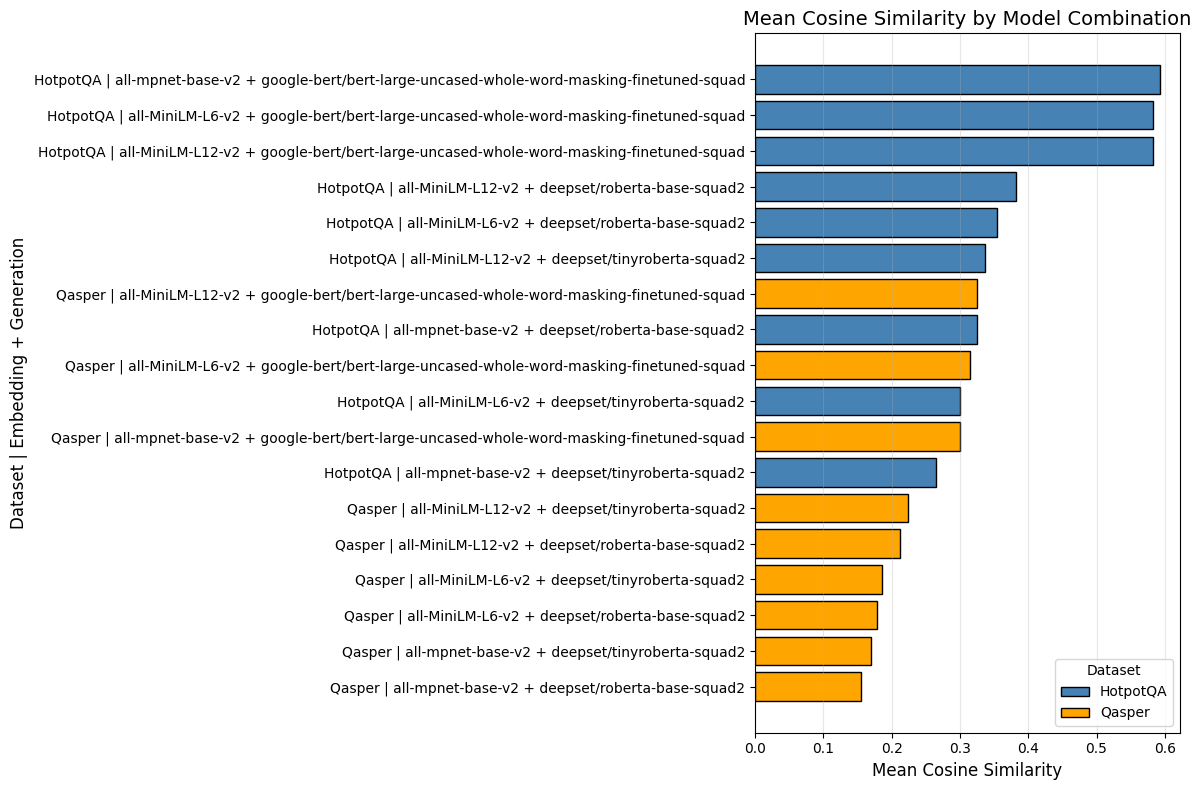

In [14]:
if not results_df.empty:
    results_sorted = results_df.sort_values("mean_cosine_sim", ascending=False).reset_index(drop=True)

    results_sorted["label"] = results_sorted.apply(
        lambda r: f"{r['dataset']} | {r['embedding']} + {r['generation']}", axis=1
    )

    dataset_colors = {
        "HotpotQA": "steelblue",   
        "Qasper":   "orange"      
    }
    bar_colors = results_sorted["dataset"].map(dataset_colors)

    plt.figure(figsize=(12, 8))
    plt.barh(results_sorted["label"],
             results_sorted["mean_cosine_sim"],
             color=bar_colors,
             edgecolor="k")

    plt.xlabel("Mean Cosine Similarity", fontsize=12)
    plt.ylabel("Dataset | Embedding + Generation", fontsize=12)
    plt.title("Mean Cosine Similarity by Model Combination", fontsize=14)
    plt.gca().invert_yaxis() 
    plt.grid(axis="x", alpha=0.3)

    from matplotlib.patches import Patch
    legend_handles = [Patch(facecolor=c, edgecolor="k", label=ds)
                      for ds, c in dataset_colors.items()]
    plt.legend(handles=legend_handles, title="Dataset")

    plt.tight_layout()
    plt.show()

### Plotting the Cosine Simmilarity vs Answer COnfidence

/tmp/ipykernel_1282502/2580934442.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(combos))
/tmp/ipykernel_1282502/2580934442.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.75, 1])


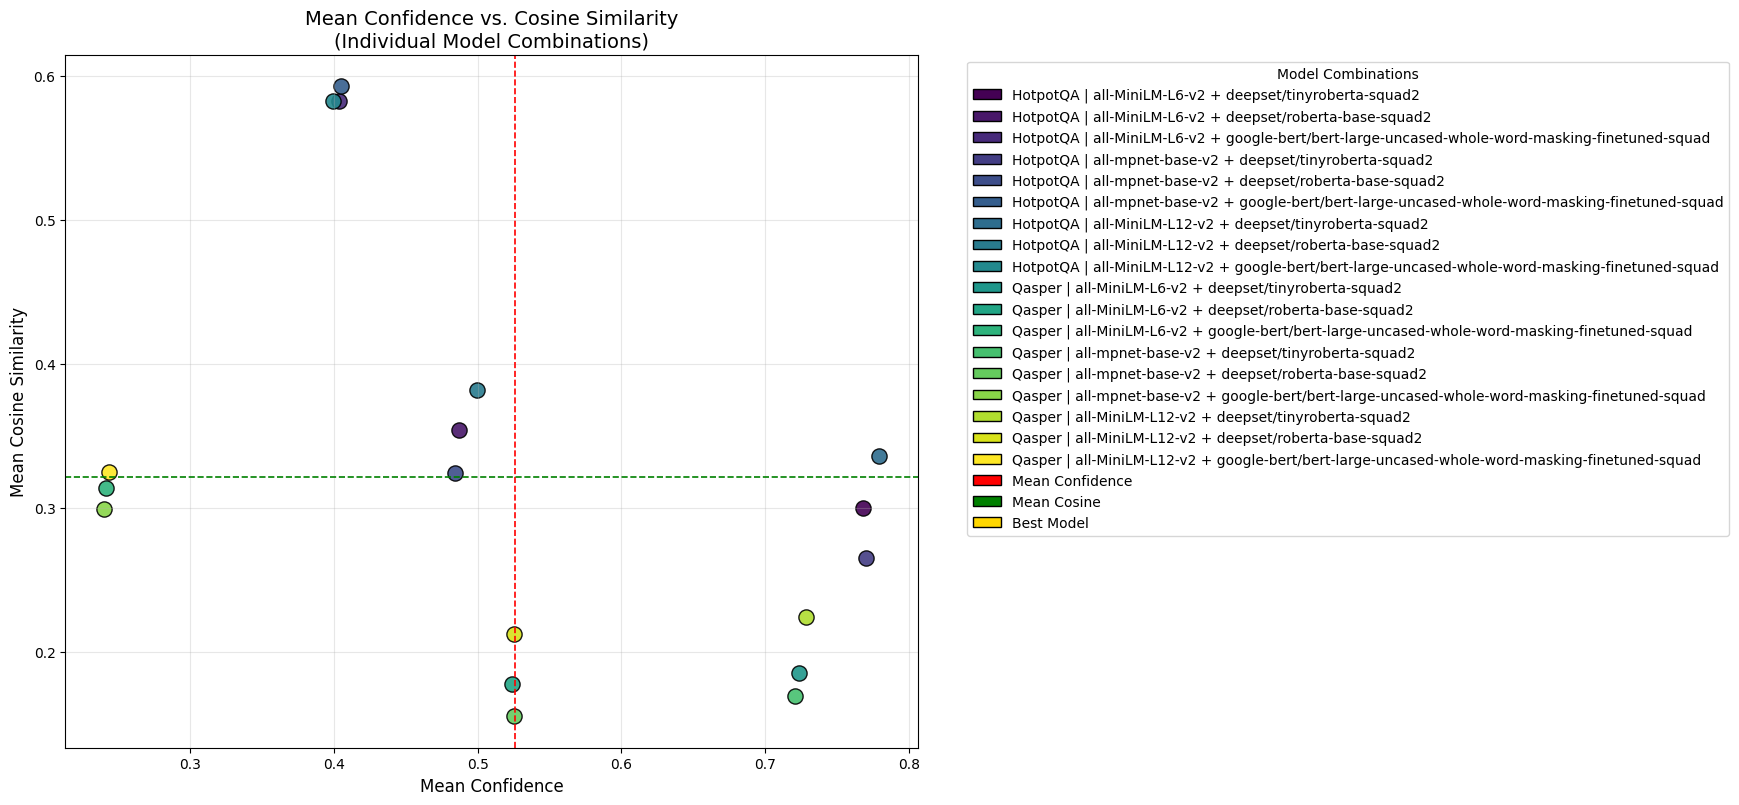

In [15]:
if not results_df.empty:
    plt.figure(figsize=(11, 9))

    results_df["combo_label"] = results_df.apply(
        lambda r: f"{r['dataset']} | {r['embedding']} + {r['generation']}", axis=1
    )
    combos = results_df["combo_label"].tolist()

    cmap = cm.get_cmap("viridis", len(combos))
    colors = [cmap(i) for i in range(len(combos))]

    # Scatter each combination with its own color
    for color, (_, row) in zip(colors, results_df.iterrows()):
        plt.scatter(row["mean_confidence"], row["mean_cosine_sim"],
                    s=120, alpha=0.9, edgecolor="k", color=color)

    # Mean reference lines
    plt.axvline(results_df["mean_confidence"].mean(), color="red",
                linestyle="--", lw=1.2, label="Mean Confidence")
    plt.axhline(results_df["mean_cosine_sim"].mean(), color="green",
                linestyle="--", lw=1.2, label="Mean Cosine")

    # Legend with combination names
    combo_handles = [Patch(facecolor=color, edgecolor="k", label=label)
                     for color, label in zip(colors, combos)]
    mean_handles = [
        Patch(facecolor="red",  edgecolor="k", label="Mean Confidence"),
        Patch(facecolor="green",edgecolor="k", label="Mean Cosine")
    ]
    if best_row is not None:
        mean_handles.append(Patch(facecolor="gold", edgecolor="k", label="Best Model"))

    plt.legend(handles=combo_handles + mean_handles,
               title="Model Combinations",
               bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.xlabel("Mean Confidence", fontsize=12)
    plt.ylabel("Mean Cosine Similarity", fontsize=12)
    plt.title("Mean Confidence vs. Cosine Similarity\n(Individual Model Combinations)", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
